<a href="https://colab.research.google.com/github/varundubey2804/Predicting-Future-Store-Sales-with-AI/blob/main/Predicting_Future_Store_Sales_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


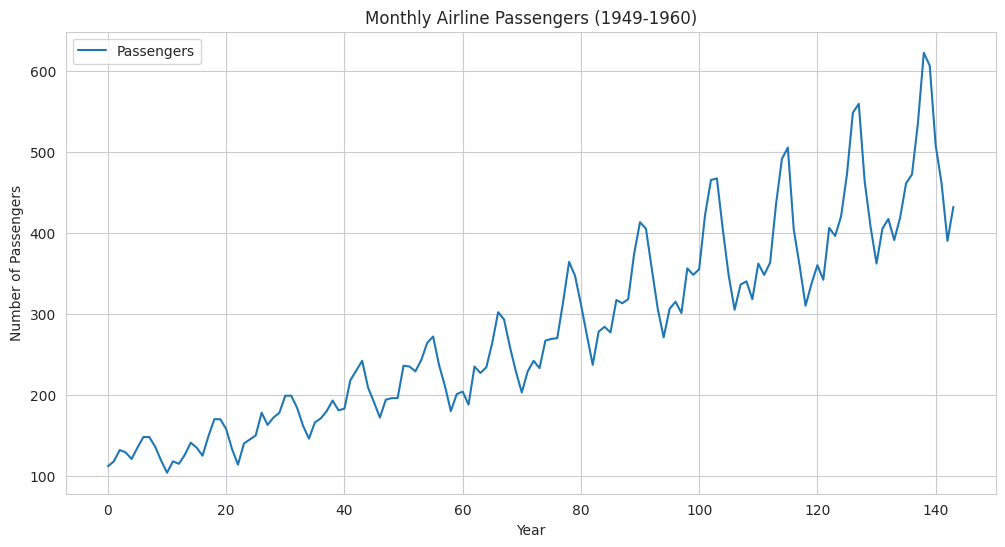

In [5]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

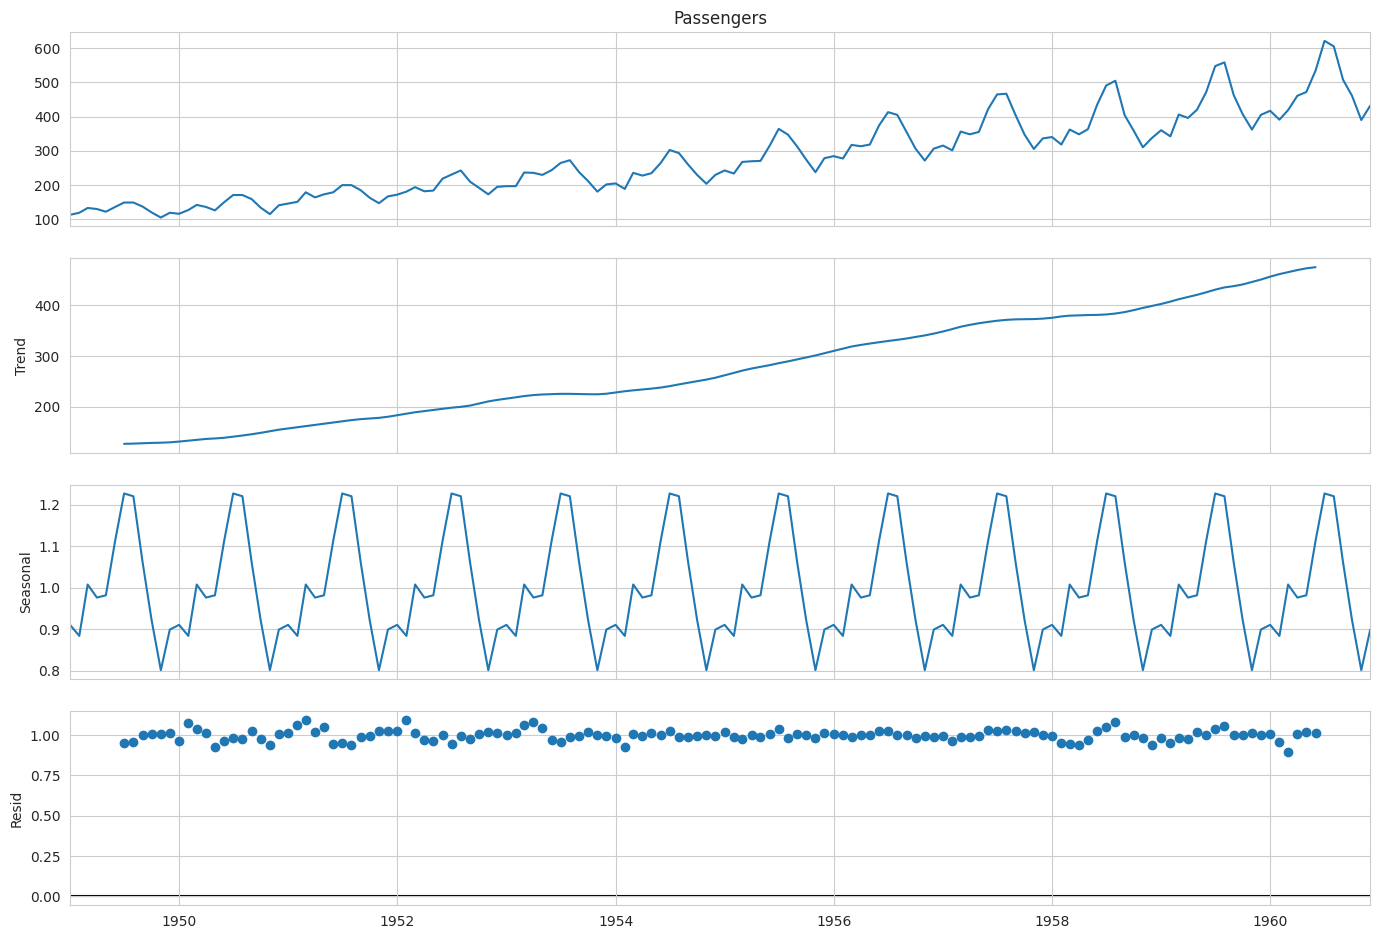

In [6]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [7]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


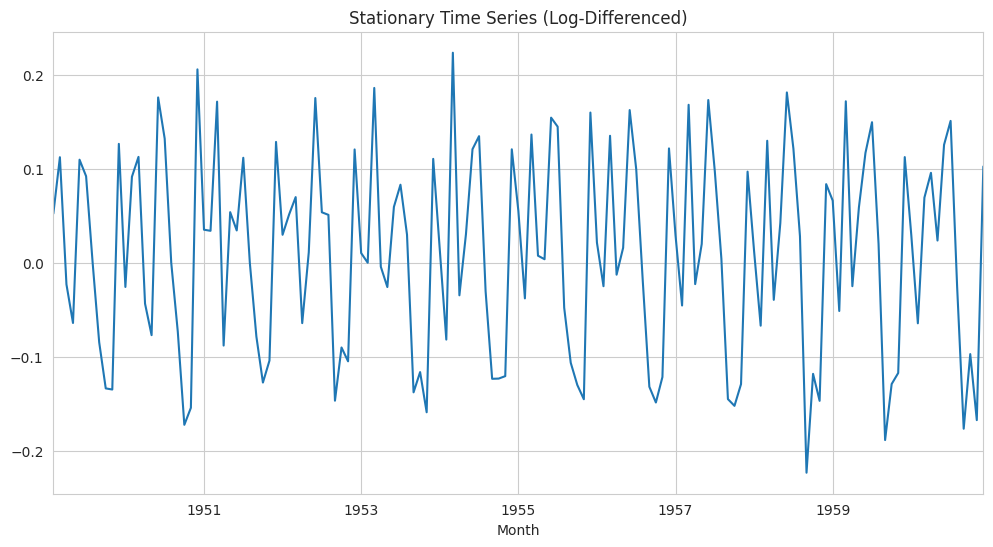

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [8]:
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

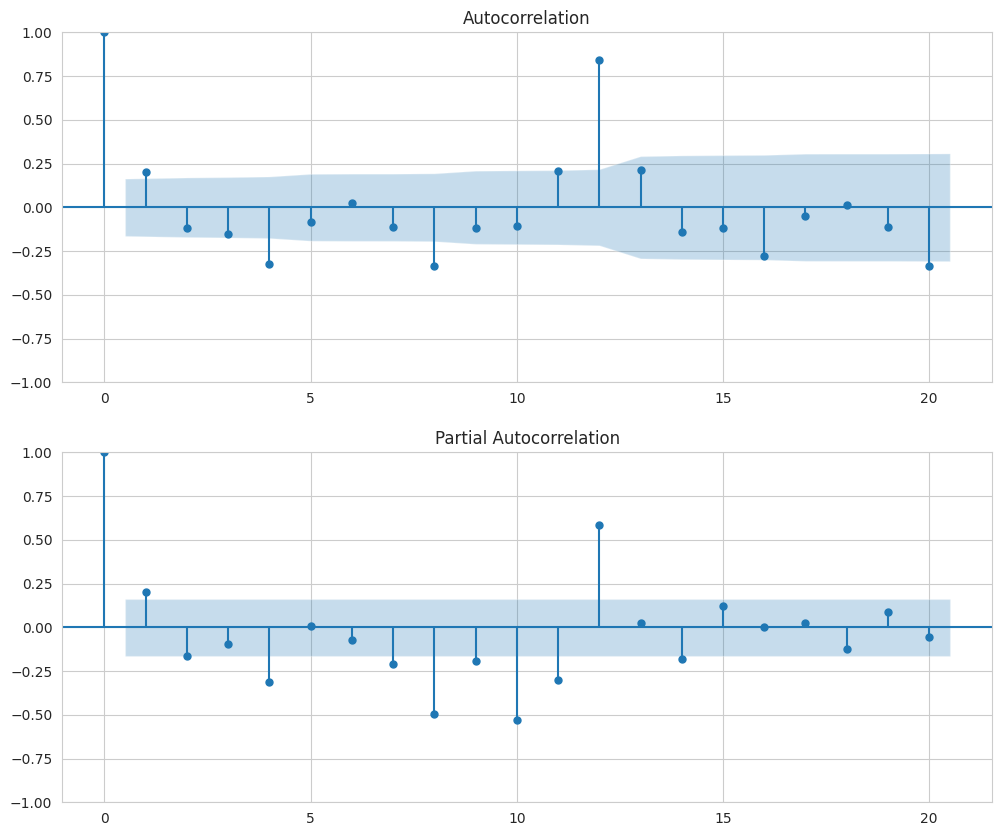

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


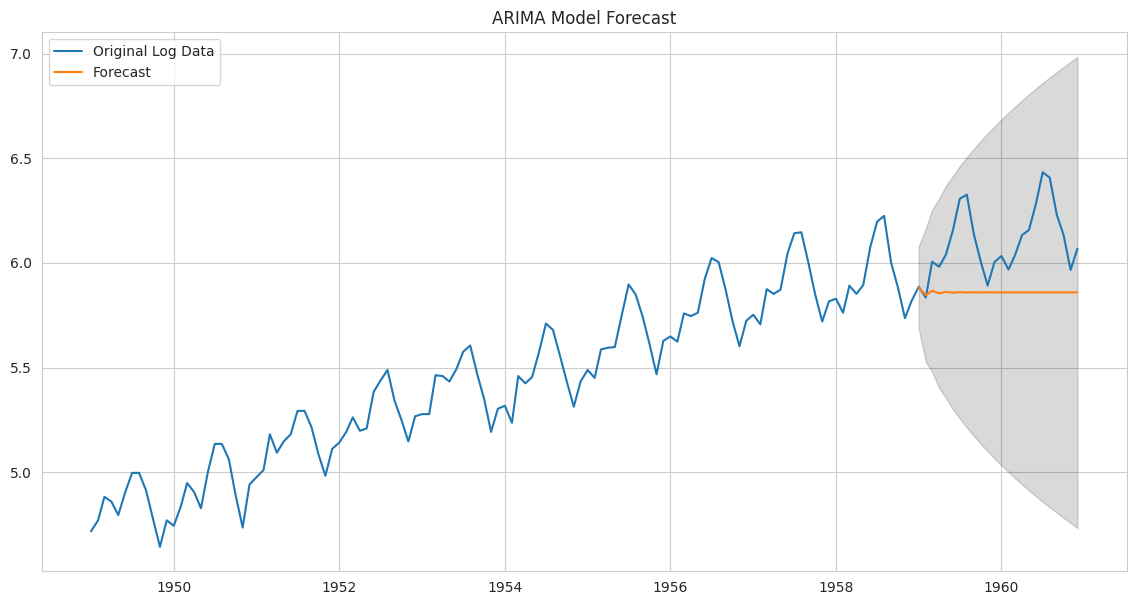

In [10]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


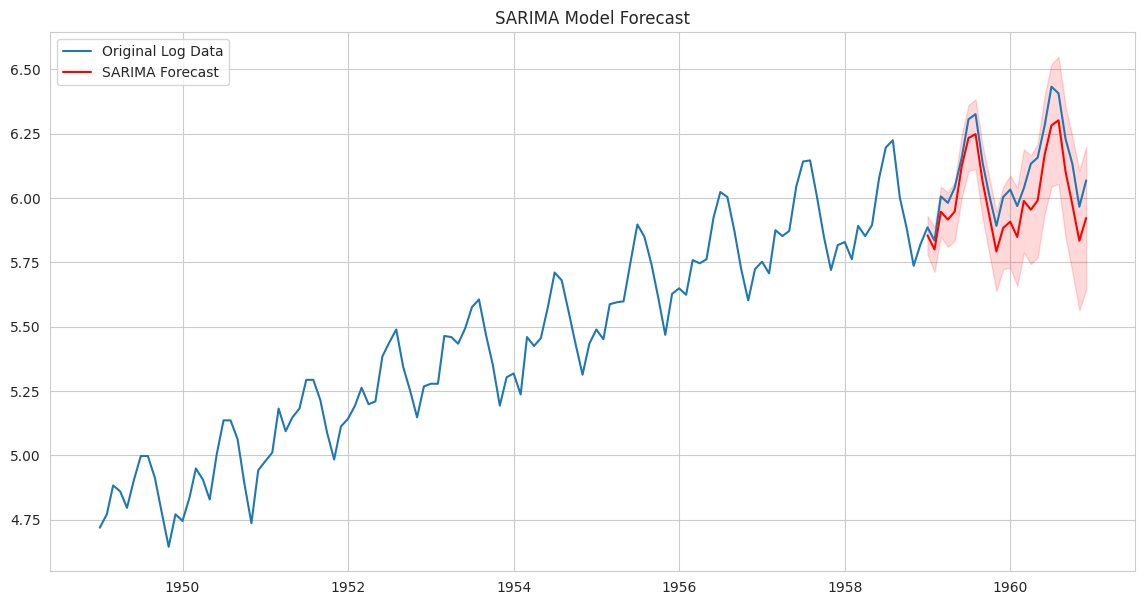

In [11]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.25


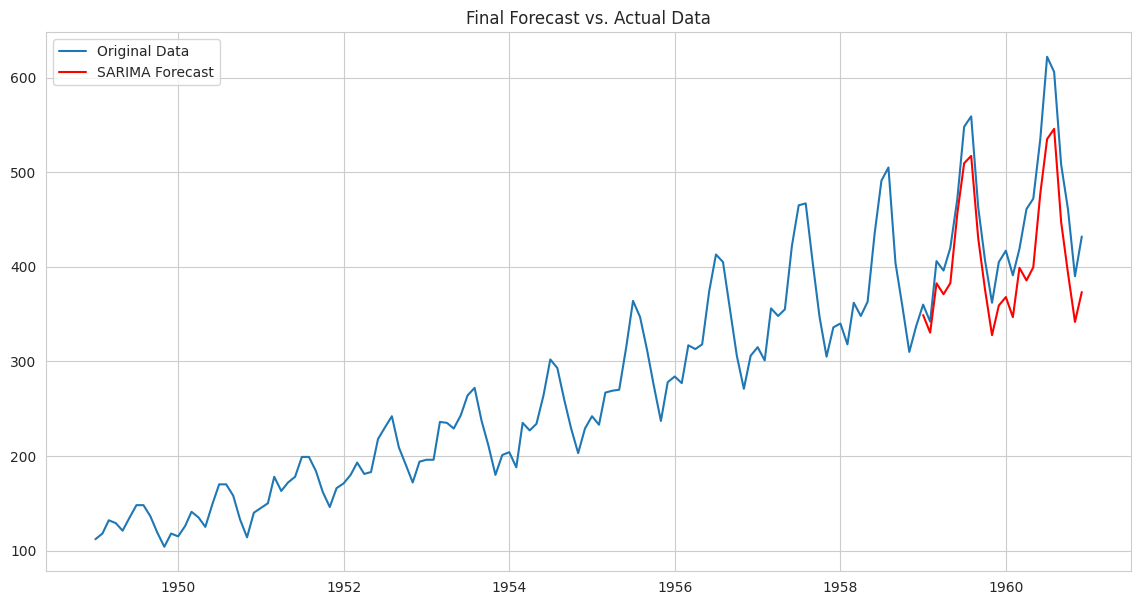

In [12]:
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

EDA — what your plots show (summary)

Trend: The Airline Passengers series (1949–1960) shows a clear upward trend — passenger numbers increase over time.

Seasonality: There is strong regular seasonality with a 12-month period (higher passengers in mid/late year months, lower early in year). The seasonal amplitude also grows with the level.

Variance (heteroscedasticity): Variance increases with level (the seasonal swings grow as the trend rises). That’s why the multiplicative decomposition and log transform are appropriate.

Outliers / structure: There are no extreme one-off spikes beyond the seasonal pattern; the series looks well behaved for standard ARIMA/SARIMA modeling after log transform and appropriate differencing.

Code to run ADF on original, log, and log-differenced series

In [13]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

# assuming df is already loaded and index set to datetime and column 'Passengers' exists
series_original = df['Passengers']

def adf_report(series, label):
    print(f"\n=== ADF Test: {label} ===")
    result = adfuller(series, autolag='AIC')
    adf_stat, p_value, usedlag, nobs, crit_vals, icbest = result[0], result[1], result[2], result[3], result[4], result[5]
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"# Lags Used: {usedlag}")
    print(f"# Observations Used: {nobs}")
    for k, v in crit_vals.items():
        print(f"Critical Value ({k}): {v:.4f}")
    return result

# Original series
adf_original = adf_report(series_original, 'Original')

# Log transform
series_log = np.log(series_original)
adf_log = adf_report(series_log.dropna(), 'Log-Transformed')

# Log-differenced (first difference of log)
series_log_diff = series_log.diff().dropna()
adf_log_diff = adf_report(series_log_diff, 'Log-Differenced (first difference)')



=== ADF Test: Original ===
ADF Statistic: 0.8154
p-value: 0.9919
# Lags Used: 13
# Observations Used: 130
Critical Value (1%): -3.4817
Critical Value (5%): -2.8840
Critical Value (10%): -2.5788

=== ADF Test: Log-Transformed ===
ADF Statistic: -1.7170
p-value: 0.4224
# Lags Used: 13
# Observations Used: 130
Critical Value (1%): -3.4817
Critical Value (5%): -2.8840
Critical Value (10%): -2.5788

=== ADF Test: Log-Differenced (first difference) ===
ADF Statistic: -2.7171
p-value: 0.0711
# Lags Used: 14
# Observations Used: 128
Critical Value (1%): -3.4825
Critical Value (5%): -2.8844
Critical Value (10%): -2.5790


How to interpret typical results (what you’ll likely see)

Original series: ADF p-value will usually be > 0.05 (fail to reject unit root) — the series is non-stationary because of trend and seasonality.

Log series: The log reduces multiplicative variance but often still shows trend + seasonality; the ADF p-value may still be > 0.05 (still non-stationary).

Log-differenced (first diff of log): This commonly rejects the null (p-value < 0.05), indicating stationarity of the differenced series. That’s consistent with ARIMA modeling with d=1 (or seasonal differencing too).

If your log-transform alone returns p < 0.05, that would be unusual for AirPassengers (the seasonality normally requires differencing), but check the numbers — if p < 0.05 for log series then non-seasonal ARIMA with d=0 could be plausible on the log series.

ARIMA model performance: build non-seasonal ARIMA (d=0) on log data and compare to SARIMA

Below is a ready-to-run code block that:

Splits train/test the same way you used (train = up to 1958, test = 1959-1960).

Fits a small grid search for ARIMA(p,0,q) with p,q in 0..3 (d=0) on the log-transformed train data (no differencing).

Selects the model with lowest AIC, fits it, forecasts, converts forecasts back by exp().

Also fits a SARIMA model (seasonal (1,1,1,12) as in your notebook) and computes its RMSE (so you can compare).

Prints AICs and RMSEs and plots results.

Best non-seasonal ARIMA order (on log data, d=0): (3, 0, 2) AIC: -202.11943662627112
Non-seasonal ARIMA (d=0) RMSE on test (original scale): 173.672
SARIMA RMSE on test (original scale): 48.248


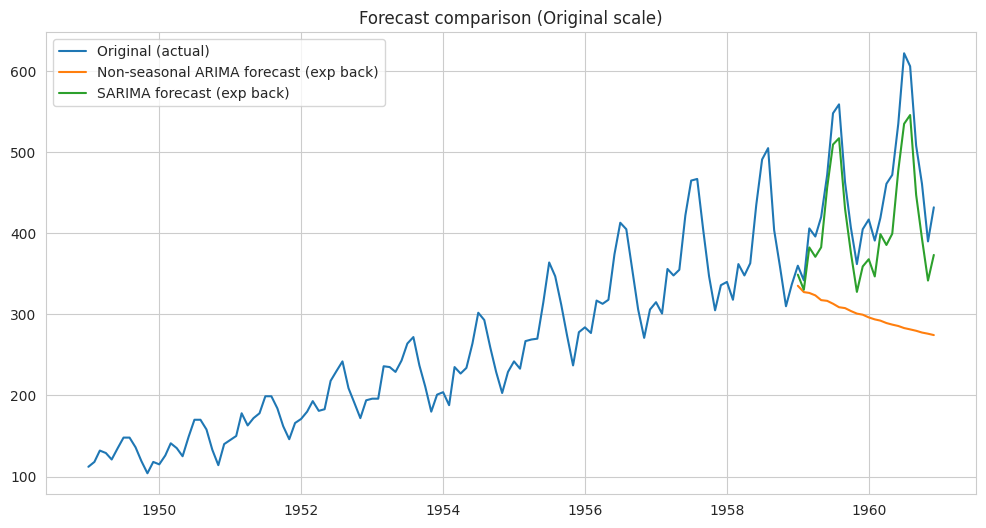

In [14]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
df['Month'] = pd.to_datetime(df.index) if not isinstance(df.index, pd.DatetimeIndex) else df.index
# make sure df.index is datetime and contains the passengers column
series = df['Passengers']
series.index = pd.DatetimeIndex(series.index, freq='MS')  # ensure monthly start freq

series_log = np.log(series)

# Train/test split (same as your notebook)
train = series_log[:'1958']
test = series_log['1959':]

# Grid search for non-seasonal ARIMA on log data with d=0
best_aic = np.inf
best_order = None
best_model = None
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(train, order=(p, 0, q), freq='MS')
            res = model.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, 0, q)
                best_model = res
        except Exception as e:
            # model failed to fit, skip
            continue

print("Best non-seasonal ARIMA order (on log data, d=0):", best_order, "AIC:", best_aic)

# Forecast with best non-seasonal ARIMA
n_steps = len(test)
forecast_nonseasonal = best_model.get_forecast(steps=n_steps)
pred_mean_nonseasonal = forecast_nonseasonal.predicted_mean
pred_ci_nonseasonal = forecast_nonseasonal.conf_int()

# Fit SARIMA (seasonal) same as your notebook, on train
sarima = sm.tsa.statespace.SARIMAX(train,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False,
                                  freq='MS')
sarima_res = sarima.fit(disp=False)
sarima_forecast = sarima_res.get_forecast(steps=n_steps)
pred_mean_sarima = sarima_forecast.predicted_mean
pred_ci_sarima = sarima_forecast.conf_int()

# Convert back from log to original scale
pred_nonseasonal_exp = np.exp(pred_mean_nonseasonal)
pred_sarima_exp = np.exp(pred_mean_sarima)
actual_exp = np.exp(test)

# Align indices
pred_nonseasonal_exp.index = test.index
pred_sarima_exp.index = test.index

# RMSE calculations (on original scale)
rmse_nonseasonal = np.sqrt(mean_squared_error(actual_exp, pred_nonseasonal_exp))
rmse_sarima = np.sqrt(mean_squared_error(actual_exp, pred_sarima_exp))

print(f"Non-seasonal ARIMA (d=0) RMSE on test (original scale): {rmse_nonseasonal:.3f}")
print(f"SARIMA RMSE on test (original scale): {rmse_sarima:.3f}")

# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(series, label='Original (actual)')
plt.plot(pred_nonseasonal_exp, label='Non-seasonal ARIMA forecast (exp back)')
plt.plot(pred_sarima_exp, label='SARIMA forecast (exp back)')
plt.legend()
plt.title('Forecast comparison (Original scale)')
plt.show()
